In [1]:
# YOLOv5 🚀 by Ultralytics, GPL-3.0 license
"""
Train a YOLOv5 model on a custom dataset

Usage:
    $ python path/to/train.py --data coco128.yaml --weights yolov5s.pt --img 640
"""

import argparse
from train_with_bcc import convert_yolo2bcc, nn_predict, convert_cs_yolo2bcc
# YOLOBCC
from train_with_bcc import read_crowdsourced_labels, init_bcc_params, \
    init_nn_output, compute_param_confusion_matrices, init_metrics, update_bcc_metrics
from lib.BCCNet.VariationalInference.VB_iteration_yolo import VB_iteration as VBi_yolo
import logging
import math
import os
import random
import sys
import time
from copy import deepcopy
from pathlib import Path

import numpy as np
import torch
import torch.distributed as dist
import torch.nn as nn
import yaml
from torch.cuda import amp
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.optim import Adam, SGD, lr_scheduler
from tqdm import tqdm

# FILE = Path(__file__).absolute()
# sys.path.append(FILE.parents[0].as_posix())  # add yolov5/ to path

import val  # for end-of-epoch mAP
from models.experimental import attempt_load
from models.yolo import Model
from utils.autoanchor import check_anchors
from utils.datasets import create_dataloader
from utils.general import labels_to_class_weights, increment_path, labels_to_image_weights, init_seeds, \
    strip_optimizer, get_latest_run, check_dataset, check_file, check_git_status, check_img_size, \
    check_requirements, print_mutation, set_logging, one_cycle, colorstr, methods
from utils.downloads import attempt_download
from utils.loss import ComputeLoss
from utils.plots import plot_labels, plot_evolve
from utils.torch_utils import EarlyStopping, ModelEMA, de_parallel, intersect_dicts, select_device, \
    torch_distributed_zero_first
from utils.loggers.wandb.wandb_utils import check_wandb_resume
from utils.metrics import fitness
from utils.loggers import Loggers
from utils.callbacks import Callbacks



LOGGER = logging.getLogger(__name__)
LOCAL_RANK = int(os.getenv('LOCAL_RANK', -1))  # https://pytorch.org/docs/stable/elastic/run.html
RANK = int(os.getenv('RANK', -1))
WORLD_SIZE = int(os.getenv('WORLD_SIZE', 1))

In [2]:
def parse_opt(known=False):
    parser = argparse.ArgumentParser()
    parser.add_argument('--bcc', action='store_true', help='Whether to run YOLO with or without BCC.')
    parser.add_argument('--weights', type=str, default='yolov5s.pt', help='initial weights path')
    parser.add_argument('--cfg', type=str, default='', help='model.yaml path')
    parser.add_argument('--data', type=str, default='data/coco128.yaml', help='dataset.yaml path')
    parser.add_argument('--hyp', type=str, default='data/hyps/hyp.scratch.yaml', help='hyperparameters path')
    parser.add_argument('--epochs', type=int, default=300)
    parser.add_argument('--batch-size', type=int, default=16, help='total batch size for all GPUs')
    parser.add_argument('--imgsz', '--img', '--img-size', type=int, default=640, help='train, val image size (pixels)')
    parser.add_argument('--rect', action='store_true', help='rectangular training')
    parser.add_argument('--resume', nargs='?', const=True, default=False, help='resume most recent training')
    parser.add_argument('--nosave', action='store_true', help='only save final checkpoint')
    parser.add_argument('--noval', action='store_true', help='only validate final epoch')
    parser.add_argument('--noautoanchor', action='store_true', help='disable autoanchor check')
    parser.add_argument('--evolve', type=int, nargs='?', const=300, help='evolve hyperparameters for x generations')
    parser.add_argument('--bucket', type=str, default='', help='gsutil bucket')
    parser.add_argument('--cache', type=str, nargs='?', const='ram', help='--cache images in "ram" (default) or "disk"')
    parser.add_argument('--image-weights', action='store_true', help='use weighted image selection for training')
    parser.add_argument('--device', default='', help='cuda device, i.e. 0 or 0,1,2,3 or cpu')
    parser.add_argument('--multi-scale', action='store_true', help='vary img-size +/- 50%%')
    parser.add_argument('--single-cls', action='store_true', help='train multi-class data as single-class')
    parser.add_argument('--adam', action='store_true', help='use torch.optim.Adam() optimizer')
    parser.add_argument('--sync-bn', action='store_true', help='use SyncBatchNorm, only available in DDP mode')
    parser.add_argument('--workers', type=int, default=8, help='maximum number of dataloader workers')
    parser.add_argument('--project', default='runs/train', help='save to project/name')
    parser.add_argument('--entity', default=None, help='W&B entity')
    parser.add_argument('--name', default='exp', help='save to project/name')
    parser.add_argument('--exist-ok', action='store_true', help='existing project/name ok, do not increment')
    parser.add_argument('--quad', action='store_true', help='quad dataloader')
    parser.add_argument('--linear-lr', action='store_true', help='linear LR')
    parser.add_argument('--label-smoothing', type=float, default=0.0, help='Label smoothing epsilon')
    parser.add_argument('--upload_dataset', action='store_true', help='Upload dataset as W&B artifact table')
    parser.add_argument('--bbox_interval', type=int, default=-1, help='Set bounding-box image logging interval for W&B')
    parser.add_argument('--save_period', type=int, default=-1, help='Log model after every "save_period" epoch')
    parser.add_argument('--artifact_alias', type=str, default="latest", help='version of dataset artifact to be used')
    parser.add_argument('--local_rank', type=int, default=-1, help='DDP parameter, do not modify')
    parser.add_argument('--freeze', type=int, default=0, help='Number of layers to freeze. backbone=10, all=24')
    parser.add_argument('--patience', type=int, default=30, help='EarlyStopping patience (epochs)')
    opt = parser.parse_known_args()[0] if known else parser.parse_args("")
    return opt

## Main

In [3]:
opt = parse_opt()
opt.data = 'data/toy.yaml'
opt.exist_ok = True
opt.cache = None
opt.workers = 0
opt.batch_size = 2 # Change this to number of train images

# Checks
set_logging(RANK)
if RANK in [-1, 0]:
    print(colorstr('train: ') + ', '.join(f'{k}={v}' for k, v in vars(opt).items()))
#     check_git_status()
#     check_requirements(requirements=FILE.parent / 'requirements.txt', exclude=['thop'])

# Resume
if opt.resume and not check_wandb_resume(opt) and not opt.evolve:  # resume an interrupted run
    ckpt = opt.resume if isinstance(opt.resume, str) else get_latest_run()  # specified or most recent path
    assert os.path.isfile(ckpt), 'ERROR: --resume checkpoint does not exist'
    with open(Path(ckpt).parent.parent / 'opt.yaml') as f:
        opt = argparse.Namespace(**yaml.safe_load(f))  # replace
    opt.cfg, opt.weights, opt.resume = '', ckpt, True  # reinstate
    LOGGER.info(f'Resuming training from {ckpt}')
else:
    opt.data, opt.cfg, opt.hyp = check_file(opt.data), check_file(opt.cfg), check_file(opt.hyp)  # check files
    assert len(opt.cfg) or len(opt.weights), 'either --cfg or --weights must be specified'
    if opt.evolve:
        opt.project = 'runs/evolve'
        opt.exist_ok = opt.resume
    opt.save_dir = str(increment_path(Path(opt.project) / opt.name, exist_ok=opt.exist_ok))

# DDP mode
device = select_device(opt.device, batch_size=opt.batch_size)
if LOCAL_RANK != -1:
    from datetime import timedelta
    assert torch.cuda.device_count() > LOCAL_RANK, 'insufficient CUDA devices for DDP command'
    assert opt.batch_size % WORLD_SIZE == 0, '--batch-size must be multiple of CUDA device count'
    assert not opt.image_weights, '--image-weights argument is not compatible with DDP training'
    assert not opt.evolve, '--evolve argument is not compatible with DDP training'
    torch.cuda.set_device(LOCAL_RANK)
    device = torch.device('cuda', LOCAL_RANK)
    dist.init_process_group(backend="nccl" if dist.is_nccl_available() else "gloo")
hyp = opt.hyp
callbacks=Callbacks()

YOLOv5 🚀 85c7316 torch 1.9.0 CPU



train: bcc=False, weights=yolov5s.pt, cfg=, data=data/toy.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=300, batch_size=2, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=0, project=runs/train, entity=None, name=exp, exist_ok=True, quad=False, linear_lr=False, label_smoothing=0.0, upload_dataset=False, bbox_interval=-1, save_period=-1, artifact_alias=latest, local_rank=-1, freeze=0, patience=30


## Train

In [45]:
save_dir, epochs, batch_size, weights, single_cls, evolve, data, cfg, resume, noval, nosave, workers, freeze, = \
    Path(opt.save_dir), opt.epochs, opt.batch_size, opt.weights, opt.single_cls, opt.evolve, opt.data, opt.cfg, \
    opt.resume, opt.noval, opt.nosave, opt.workers, opt.freeze

# Directories
w = save_dir / 'weights'  # weights dir
w.mkdir(parents=True, exist_ok=True)  # make dir
last, best = w / 'last.pt', w / 'best.pt'

# Hyperparameters
if isinstance(hyp, str):
    with open(hyp) as f:
        hyp = yaml.safe_load(f)  # load hyps dict
LOGGER.info(colorstr('hyperparameters: ') + ', '.join(f'{k}={v}' for k, v in hyp.items()))

# Save run settings
with open(save_dir / 'hyp.yaml', 'w') as f:
    yaml.safe_dump(hyp, f, sort_keys=False)
with open(save_dir / 'opt.yaml', 'w') as f:
    yaml.safe_dump(vars(opt), f, sort_keys=False)
data_dict = {
    'path': '../../datasets/toy',  # dataset root dir
    'train': 'images/train',  # train images (relative to 'path') 128 images
    'val': 'images/val',  # val images (relative to 'path') 128 images
    'test': 'images/test', # test images (optional)
    'nc': 2,  # number of classes
    'names': ['bone-loss', 'dental-caries']  # class names
}
for x in ['train', 'val', 'test']:
    data_dict[x] = os.path.join(data_dict['path'], data_dict[x])

# Loggers
if RANK in [-1, 0]:
    loggers = Loggers(save_dir, weights, opt, hyp, LOGGER)  # loggers instance
    if loggers.wandb:
        data_dict = loggers.wandb.data_dict
        if resume:
            weights, epochs, hyp = opt.weights, opt.epochs, opt.hyp

    # Register actions
    for k in methods(loggers):
        callbacks.register_action(k, callback=getattr(loggers, k))

# Config
plots = not evolve  # create plots
cuda = device.type != 'cpu'
init_seeds(1 + RANK)
with torch_distributed_zero_first(RANK):
    data_dict = data_dict or check_dataset(data)  # check if None
train_path, val_path = data_dict['train'], data_dict['val']
nc = 1 if single_cls else int(data_dict['nc'])  # number of classes
names = ['item'] if single_cls and len(data_dict['names']) != 1 else data_dict['names']  # class names
assert len(names) == nc, f'{len(names)} names found for nc={nc} dataset in {data}'  # check
is_coco = data.endswith('coco.yaml') and nc == 80  # COCO dataset

# Model
pretrained = weights.endswith('.pt')
if pretrained:
    with torch_distributed_zero_first(RANK):
        weights = attempt_download(weights)  # download if not found locally
    ckpt = torch.load(weights, map_location=device)  # load checkpoint
    model = Model(cfg or ckpt['model'].yaml, ch=3, nc=nc, anchors=hyp.get('anchors')).to(device)  # create
    exclude = ['anchor'] if (cfg or hyp.get('anchors')) and not resume else []  # exclude keys
    csd = ckpt['model'].float().state_dict()  # checkpoint state_dict as FP32
    csd = intersect_dicts(csd, model.state_dict(), exclude=exclude)  # intersect
    model.load_state_dict(csd, strict=False)  # load
    LOGGER.info(f'Transferred {len(csd)}/{len(model.state_dict())} items from {weights}')  # report
else:
    model = Model(cfg, ch=3, nc=nc, anchors=hyp.get('anchors')).to(device)  # create

# Freeze
freeze = [f'model.{x}.' for x in range(freeze)]  # layers to freeze
for k, v in model.named_parameters():
    v.requires_grad = True  # train all layers
    if any(x in k for x in freeze):
        print(f'freezing {k}')
        v.requires_grad = False

# Optimizer
nbs = 64  # nominal batch size
accumulate = max(round(nbs / batch_size), 1)  # accumulate loss before optimizing
hyp['weight_decay'] *= batch_size * accumulate / nbs  # scale weight_decay
LOGGER.info(f"Scaled weight_decay = {hyp['weight_decay']}")

g0, g1, g2 = [], [], []  # optimizer parameter groups
for v in model.modules():
    if hasattr(v, 'bias') and isinstance(v.bias, nn.Parameter):  # bias
        g2.append(v.bias)
    if isinstance(v, nn.BatchNorm2d):  # weight (no decay)
        g0.append(v.weight)
    elif hasattr(v, 'weight') and isinstance(v.weight, nn.Parameter):  # weight (with decay)
        g1.append(v.weight)

if opt.adam:
    optimizer = Adam(g0, lr=hyp['lr0'], betas=(hyp['momentum'], 0.999))  # adjust beta1 to momentum
else:
    optimizer = SGD(g0, lr=hyp['lr0'], momentum=hyp['momentum'], nesterov=True)

optimizer.add_param_group({'params': g1, 'weight_decay': hyp['weight_decay']})  # add g1 with weight_decay
optimizer.add_param_group({'params': g2})  # add g2 (biases)
LOGGER.info(f"{colorstr('optimizer:')} {type(optimizer).__name__} with parameter groups "
            f"{len(g0)} weight, {len(g1)} weight (no decay), {len(g2)} bias")
del g0, g1, g2

# Scheduler
if opt.linear_lr:
    lf = lambda x: (1 - x / (epochs - 1)) * (1.0 - hyp['lrf']) + hyp['lrf']  # linear
else:
    lf = one_cycle(1, hyp['lrf'], epochs)  # cosine 1->hyp['lrf']
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lf)  # plot_lr_scheduler(optimizer, scheduler, epochs)

# EMA
ema = ModelEMA(model) if RANK in [-1, 0] else None

# Resume
start_epoch, best_fitness = 0, 0.0
if pretrained:
    # Optimizer
    if ckpt['optimizer'] is not None:
        optimizer.load_state_dict(ckpt['optimizer'])
        best_fitness = ckpt['best_fitness']

    # EMA
    if ema and ckpt.get('ema'):
        ema.ema.load_state_dict(ckpt['ema'].float().state_dict())
        ema.updates = ckpt['updates']

    # Epochs
    start_epoch = ckpt['epoch'] + 1
    if resume:
        assert start_epoch > 0, f'{weights} training to {epochs} epochs is finished, nothing to resume.'
    if epochs < start_epoch:
        LOGGER.info(f"{weights} has been trained for {ckpt['epoch']} epochs. Fine-tuning for {epochs} more epochs.")
        epochs += ckpt['epoch']  # finetune additional epochs

    del ckpt, csd

# Image sizes
gs = max(int(model.stride.max()), 32)  # grid size (max stride)
nl = model.model[-1].nl  # number of detection layers (used for scaling hyp['obj'])
imgsz = check_img_size(opt.imgsz, gs, floor=gs * 2)  # verify imgsz is gs-multiple

# DP mode
if cuda and RANK == -1 and torch.cuda.device_count() > 1:
    logging.warning('DP not recommended, instead use torch.distributed.run for best DDP Multi-GPU results.\n'
                    'See Multi-GPU Tutorial at https://github.com/ultralytics/yolov5/issues/475 to get started.')
    model = torch.nn.DataParallel(model)

# SyncBatchNorm
if opt.sync_bn and cuda and RANK != -1:
    model = torch.nn.SyncBatchNorm.convert_sync_batchnorm(model).to(device)
    LOGGER.info('Using SyncBatchNorm()')

# Trainloader
train_loader, dataset = create_dataloader(train_path, imgsz, batch_size // WORLD_SIZE, gs, single_cls,
                                          hyp=hyp, augment=True, cache=opt.cache, rect=opt.rect, rank=RANK,
                                          workers=workers, image_weights=opt.image_weights, quad=opt.quad,
                                          prefix=colorstr('train: '))
# YOLOBCC
# TODO: Verify the following (is nl == ng?):
n_grid_choices, n_anchor_choices = model.model[-1].nl, model.model[-1].na
grid_ratios = model.model[-1].stride.cpu().detach().numpy() / imgsz
cstargets_all = read_crowdsourced_labels(data_dict)
cstargets_all_bcc = convert_cs_yolo2bcc(cstargets_all, n_anchor_choices, nc, grid_ratios)
cstargets = cstargets_all['train']
cstargets_bcc = cstargets_all_bcc['train']
mlc = int(np.concatenate(dataset.labels, 0)[:, 0].max())  # max label class
nb = len(train_loader)  # number of batches
assert mlc < nc, f'Label class {mlc} exceeds nc={nc} in {data}. Possible class labels are 0-{nc - 1}'

# Process 0
if RANK in [-1, 0]:
    val_loader, val_dataset = create_dataloader(val_path, imgsz, batch_size // WORLD_SIZE * 2, gs, single_cls,
                                   hyp=hyp, cache=None if noval else opt.cache, rect=True, rank=-1,
                                   workers=workers, pad=0.5,
                                   prefix=colorstr('val: '))

    if not resume:
        labels = np.concatenate(dataset.labels, 0)
        # c = torch.tensor(labels[:, 0])  # classes
        # cf = torch.bincount(c.long(), minlength=nc) + 1.  # frequency
        # model._initialize_biases(cf.to(device))
        if plots:
            plot_labels(labels, names, save_dir)

        # Anchors
        if not opt.noautoanchor:
            check_anchors(dataset, model=model, thr=hyp['anchor_t'], imgsz=imgsz)
        model.half().float()  # pre-reduce anchor precision

    callbacks.on_pretrain_routine_end()

# DDP mode
if cuda and RANK != -1:
    model = DDP(model, device_ids=[LOCAL_RANK], output_device=LOCAL_RANK)

# Model parameters
hyp['box'] *= 3. / nl  # scale to layers
hyp['cls'] *= nc / 80. * 3. / nl  # scale to classes and layers
hyp['obj'] *= (imgsz / 640) ** 2 * 3. / nl  # scale to image size and layers
hyp['label_smoothing'] = opt.label_smoothing
model.nc = nc  # attach number of classes to model
model.hyp = hyp  # attach hyperparameters to model
model.class_weights = labels_to_class_weights(dataset.labels, nc).to(device) * nc  # attach class weights
model.names = names

# Start training
t0 = time.time()
nw = max(round(hyp['warmup_epochs'] * nb), 1000)  # number of warmup iterations, max(3 epochs, 1k iterations)
# nw = min(nw, (epochs - start_epoch) / 2 * nb)  # limit warmup to < 1/2 of training
last_opt_step = -1
maps = np.zeros(nc)  # mAP per class
results = (0, 0, 0, 0, 0, 0, 0)  # P, R, mAP@.5, mAP@.5-.95, val_loss(box, obj, cls)
scheduler.last_epoch = start_epoch - 1  # do not move
scaler = amp.GradScaler(enabled=cuda)
stopper = EarlyStopping(patience=opt.patience)
compute_loss = ComputeLoss(model)  # init loss class
# YOLOBCC
bcc_params = init_bcc_params()
bcc_params['n_epoch'] = epochs
pcm = compute_param_confusion_matrices(bcc_params)
pred0_bcc = init_nn_output(dataset.n, grid_ratios, n_anchor_choices, bcc_params)
bcc_metrics = init_metrics(bcc_params['n_epoch'])
LOGGER.info(f'Image sizes {imgsz} train, {imgsz} val\n'
            f'Using {train_loader.num_workers} dataloader workers\n'
            f"Logging results to {colorstr('bold', save_dir)}\n"
            f'Starting training for {epochs} epochs...')
for epoch in range(start_epoch, epochs):  # epoch ------------------------------------------------------------------
    model.train()
    if epoch == start_epoch:
        pred_bcc = pred0_bcc

    # Update image weights (optional, single-GPU only)
    if opt.image_weights:
        cw = model.class_weights.cpu().numpy() * (1 - maps) ** 2 / nc  # class weights
        iw = labels_to_image_weights(dataset.labels, nc=nc, class_weights=cw)  # image weights
        dataset.indices = random.choices(range(dataset.n), weights=iw, k=dataset.n)  # rand weighted idx

    # Update mosaic border (optional)
    # b = int(random.uniform(0.25 * imgsz, 0.75 * imgsz + gs) // gs * gs)
    # dataset.mosaic_border = [b - imgsz, -b]  # height, width borders

    # GOVIND0: Find mean losses by comparing pred with `qtargets`, not `targets`. Look for pointer GOVIND1
    mloss = torch.zeros(3, device=device)  # mean losses
    if RANK != -1:
        train_loader.sampler.set_epoch(epoch)
    pbar = enumerate(train_loader)
    LOGGER.info(('\n' + '%10s' * 7) % ('Epoch', 'gpu_mem', 'box', 'obj', 'cls', 'labels', 'img_size'))
    if RANK in [-1, 0]:
        pbar = tqdm(pbar, total=nb)  # progress bar
    optimizer.zero_grad()

    # YOLOBCC
    qtargets, pcm['variational'], lb = VBi_yolo(cstargets_bcc, pred_bcc, pcm['variational'], pcm['prior'])
    for i, (imgs, targets, paths, _) in pbar:  # batch -------------------------------------------------------------
        # YOLOBCC
        batch_qtargets = qtargets
        ni = i + nb * epoch  # number integrated batches (since train start)
        imgs = imgs.to(device, non_blocking=True).float() / 255.0  # uint8 to float32, 0-255 to 0.0-1.0

        # Warmup
        if ni <= nw:
            xi = [0, nw]  # x interp
            # compute_loss.gr = np.interp(ni, xi, [0.0, 1.0])  # iou loss ratio (obj_loss = 1.0 or iou)
            accumulate = max(1, np.interp(ni, xi, [1, nbs / batch_size]).round())
            for j, x in enumerate(optimizer.param_groups):
                # bias lr falls from 0.1 to lr0, all other lrs rise from 0.0 to lr0
                x['lr'] = np.interp(ni, xi, [hyp['warmup_bias_lr'] if j == 2 else 0.0, x['initial_lr'] * lf(epoch)])
                if 'momentum' in x:
                    x['momentum'] = np.interp(ni, xi, [hyp['warmup_momentum'], hyp['momentum']])

        # Multi-scale
        if opt.multi_scale:
            sz = random.randrange(imgsz * 0.5, imgsz * 1.5 + gs) // gs * gs  # size
            sf = sz / max(imgs.shape[2:])  # scale factor
            if sf != 1:
                ns = [math.ceil(x * sf / gs) * gs for x in imgs.shape[2:]]  # new shape (stretched to gs-multiple)
                imgs = nn.functional.interpolate(imgs, size=ns, mode='bilinear', align_corners=False)

        # Forward
        with amp.autocast(enabled=cuda):
            model.eval()
            pred_yolo = nn_predict(model, imgs)
            pred_bcc = torch.log(pred_yolo[:, ..., 5:]/pred_yolo[:,...,5:].sum(2).unsqueeze(-1))
            # pred_bcc = convert_yolo2bcc(pred_yolo.cpu().detach().numpy(), n_anchor_choices, nc, grid_ratios, intermediate_yolo_mode=True)
            model.train()
            pred = model(imgs)  # forward
            # GOVIND1: Don't compare w.r.t. targets, but w.r.t. qtargets (generated by BCC)
            # YOLOBCC
            loss, loss_items = compute_loss(pred, batch_qtargets)  # loss scaled by batch_size
            if RANK != -1:
                loss *= WORLD_SIZE  # gradient averaged between devices in DDP mode
            if opt.quad:
                loss *= 4.

#         # Backward
#         scaler.scale(loss).backward()

#         # Optimize
#         if ni - last_opt_step >= accumulate:
#             scaler.step(optimizer)  # optimizer.step
#             scaler.update()
#             optimizer.zero_grad()
#             if ema:
#                 ema.update(model)
#             last_opt_step = ni

#         # Log
#         if RANK in [-1, 0]:
#             mloss = (mloss * i + loss_items) / (i + 1)  # update mean losses
#             mem = f'{torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0:.3g}G'  # (GB)
#             pbar.set_description(('%10s' * 2 + '%10.4g' * 5) % (
#                 f'{epoch}/{epochs - 1}', mem, *mloss, targets.shape[0], imgs.shape[-1]))
#             callbacks.on_train_batch_end(ni, model, imgs, targets, paths, plots, opt.sync_bn)
#         # end batch ------------------------------------------------------------------------------------------------

#     # Scheduler
#     lr = [x['lr'] for x in optimizer.param_groups]  # for loggers
#     scheduler.step()

#     if RANK in [-1, 0]:
#         # mAP
#         callbacks.on_train_epoch_end(epoch=epoch)
#         ema.update_attr(model, include=['yaml', 'nc', 'hyp', 'names', 'stride', 'class_weights'])
#         final_epoch = epoch + 1 == epochs
#         if not noval or final_epoch:  # Calculate mAP
#             results, maps, _ = val.run(data_dict,
#                                        batch_size=batch_size // WORLD_SIZE * 2,
#                                        imgsz=imgsz,
#                                        model=ema.ema,
#                                        single_cls=single_cls,
#                                        dataloader=val_loader,
#                                        save_dir=save_dir,
#                                        save_json=is_coco and final_epoch,
#                                        verbose=nc < 50 and final_epoch,
#                                        plots=plots and final_epoch,
#                                        callbacks=callbacks,
#                                        compute_loss=compute_loss)
#             # YOLOBCC
#             yhat_train = pred
#             y_train = dataset.labels
#             yhat_test = results
#             y_test = val_dataset.labels
#             update_bcc_metrics(bcc_metrics, qtargets, yhat_train, y_train, yhat_test, y_test, epoch)
#         # Update best mAP
#         fi = fitness(np.array(results).reshape(1, -1))  # weighted combination of [P, R, mAP@.5, mAP@.5-.95]
#         if fi > best_fitness:
#             best_fitness = fi
#         log_vals = list(mloss) + list(results) + lr
#         callbacks.on_fit_epoch_end(log_vals, epoch, best_fitness, fi)

#         # Save model
#         if (not nosave) or (final_epoch and not evolve):  # if save
#             ckpt = {'epoch': epoch,
#                     'best_fitness': best_fitness,
#                     'model': deepcopy(de_parallel(model)).half(),
#                     'ema': deepcopy(ema.ema).half(),
#                     'updates': ema.updates,
#                     'optimizer': optimizer.state_dict(),
#                     'wandb_id': loggers.wandb.wandb_run.id if loggers.wandb else None}

#             # Save last, best and delete
#             torch.save(ckpt, last)
#             if best_fitness == fi:
#                 torch.save(ckpt, best)
#             del ckpt
#             callbacks.on_model_save(last, epoch, final_epoch, best_fitness, fi)

#         # Stop Single-GPU
#         if stopper(epoch=epoch, fitness=fi):
#             break

        # Stop DDP TODO: known issues shttps://github.com/ultralytics/yolov5/pull/4576
        # stop = stopper(epoch=epoch, fitness=fi)
        # if RANK == 0:
        #    dist.broadcast_object_list([stop], 0)  # broadcast 'stop' to all ranks

    # Stop DPP
    # with torch_distributed_zero_first(RANK):
    # if stop:
    #    break  # must break all DDP ranks

    # end epoch ----------------------------------------------------------------------------------------------------
# end training -----------------------------------------------------------------------------------------------------
# if RANK in [-1, 0]:
#     LOGGER.info(f'\n{epoch - start_epoch + 1} epochs completed in {(time.time() - t0) / 3600:.3f} hours.')
#     if not evolve:
#         if is_coco:  # COCO dataset
#             for m in [last, best] if best.exists() else [last]:  # speed, mAP tests
#                 results, _, _ = val.run(data_dict,
#                                         batch_size=batch_size // WORLD_SIZE * 2,
#                                         imgsz=imgsz,
#                                         model=attempt_load(m, device).half(),
#                                         iou_thres=0.7,  # NMS IoU threshold for best pycocotools results
#                                         single_cls=single_cls,
#                                         dataloader=val_loader,
#                                         save_dir=save_dir,
#                                         save_json=True,
#                                         plots=False)
#         # Strip optimizers
#         for f in last, best:
#             if f.exists():
#                 strip_optimizer(f)  # strip optimizers
#     callbacks.on_train_end(last, best, plots, epoch)
#     LOGGER.info(f"Results saved to {colorstr('bold', save_dir)}")

# torch.cuda.empty_cache()

hyperparameters: lr0=0.01, lrf=0.2, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.012500000000000002, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0, translate=0.1, scale=0.5, shear=0.0, perspective=0.0, flipud=0.0, fliplr=0.5, mosaic=1.0, mixup=0.0, copy_paste=0.0, label_smoothing=0.0
TensorBoard: Start with 'tensorboard --logdir runs/train', view at http://localhost:6006/
Overriding model.yaml nc=80 with nc=2

                 from  n    params  module                                  arguments                     
  0                -1  1      3520  models.common.Focus                     [3, 32, 3]                    
  1                -1  1     18560  models.common.Conv                      [32, 64, 3, 2]                
  2                -1  1     18816  models.common.C3                        [64, 64, 1]                   
  3              

Weights & Biases: run 'pip install wandb' to automatically track and visualize YOLOv5 🚀 runs (RECOMMENDED)


Model Summary: 283 layers, 7066239 parameters, 7066239 gradients, 16.4 GFLOPs

Transferred 356/362 items from yolov5s.pt
Scaled weight_decay = 0.0005
optimizer: SGD with parameter groups 59 weight, 62 weight (no decay), 62 bias
train: Scanning '../../datasets/toy/labels/train.cache' images and labels... 2 found, 0 missing, 0 empty, 0 corrupted: 100%|██████████| 2/2 [00:00<?, ?it/s]
val: Scanning '../../datasets/toy/labels/val.cache' images and labels... 2 found, 0 missing, 0 empty, 0 corrupted: 100%|██████████| 2/2 [00:00<?, ?it/s]


Plotting labels... 


Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/train/exp
Starting training for 300 epochs...

     Epoch   gpu_mem       box       obj       cls    labels  img_size
  0%|          | 0/1 [00:00<?, ?it/s]


autoanchor: Analyzing anchors... anchors/target = 5.25, Best Possible Recall (BPR) = 1.0000


TypeError: nn_predict() missing 1 required positional argument: 'imgsz'

In [6]:
targets

tensor([[0.00000, 1.00000, 0.88198, 0.25097, 0.23605, 0.34157],
        [0.00000, 1.00000, 0.06314, 0.96187, 0.11768, 0.07625],
        [0.00000, 1.00000, 0.88198, 0.95567, 0.23605, 0.08866],
        [1.00000, 1.00000, 0.70382, 0.22487, 0.10148, 0.13008],
        [1.00000, 1.00000, 0.65358, 0.52574, 0.09849, 0.12214],
        [1.00000, 0.00000, 0.20689, 0.50936, 0.12237, 0.11121],
        [1.00000, 1.00000, 0.70382, 0.92988, 0.10148, 0.13008]])

In [46]:
model.eval()
pred_yolo = nn_predict(model, imgs, imgsz, True)
pred_yolo.shape, pred_yolo

(torch.Size([2, 25200, 5]),
 tensor([[[0.00000e+00, 7.65333e-03, 1.65895e-02, 1.65406e+01, 1.60353e+00],
          [0.00000e+00, 2.08052e-02, 1.68132e-02, 1.60026e+01, 5.38177e+00],
          [0.00000e+00, 3.39844e-02, 1.69450e-02, 1.75319e+01, 4.99813e+00],
          ...,
          [1.00000e+00, 8.60311e-01, 9.81216e-01, 1.83246e+02, 1.48857e+02],
          [1.00000e+00, 9.06831e-01, 9.81044e-01, 1.76950e+02, 1.83929e+02],
          [1.00000e+00, 9.63069e-01, 9.75258e-01, 2.05243e+02, 2.40442e+02]],
 
         [[0.00000e+00, 8.76878e-04, 1.08857e-02, 1.29762e+01, 5.46384e+00],
          [0.00000e+00, 1.40850e-02, 7.96004e-03, 1.16942e+01, 1.56954e+01],
          [0.00000e+00, 2.65246e-02, 7.02136e-03, 9.31344e+00, 1.66307e+01],
          ...,
          [1.00000e+00, 8.72294e-01, 9.73872e-01, 3.58376e+02, 2.40106e+02],
          [1.00000e+00, 9.19599e-01, 9.76089e-01, 3.39688e+02, 2.05044e+02],
          [1.00000e+00, 9.67508e-01, 9.84302e-01, 2.03486e+02, 1.21289e+02]]], grad_fn=<AsSt

In [47]:
pred_bcc = torch.log(pred_yolo[:, ..., 5:]/pred_yolo[:,...,5:].sum(2).unsqueeze(-1))
# pred_bcc = convert_yolo2bcc(pred_yolo.cpu().detach().numpy(), n_anchor_choices, nc, grid_ratios, intermediate_yolo_mode=True)
model.train()
pred = model(imgs)  # forward

In [63]:
!cat ../../datasets/toy/labels/train/train*.txt

1 0.7167199148029819 0.2063380281690141 0.10862619808306709 0.18450704225352113
1 0.6629392971246006 0.6330985915492958 0.10543130990415335 0.1732394366197183
0 0.1847710330138445 0.6098591549295774 0.13099041533546327 0.15774647887323945
1 0.5213219616204691 0.30277777777777776 0.31544562899786777 0.41095555555555563


In [49]:
targets.shape, targets

(torch.Size([7, 6]),
 tensor([[0.00000, 1.00000, 0.88198, 0.25097, 0.23605, 0.34157],
         [0.00000, 1.00000, 0.06314, 0.96187, 0.11768, 0.07625],
         [0.00000, 1.00000, 0.88198, 0.95567, 0.23605, 0.08866],
         [1.00000, 1.00000, 0.70382, 0.22487, 0.10148, 0.13008],
         [1.00000, 1.00000, 0.65358, 0.52574, 0.09849, 0.12214],
         [1.00000, 0.00000, 0.20689, 0.50936, 0.12237, 0.11121],
         [1.00000, 1.00000, 0.70382, 0.92988, 0.10148, 0.13008]]))

In [27]:
import os


'../../datasets/toy/images/train/train1.jpg'

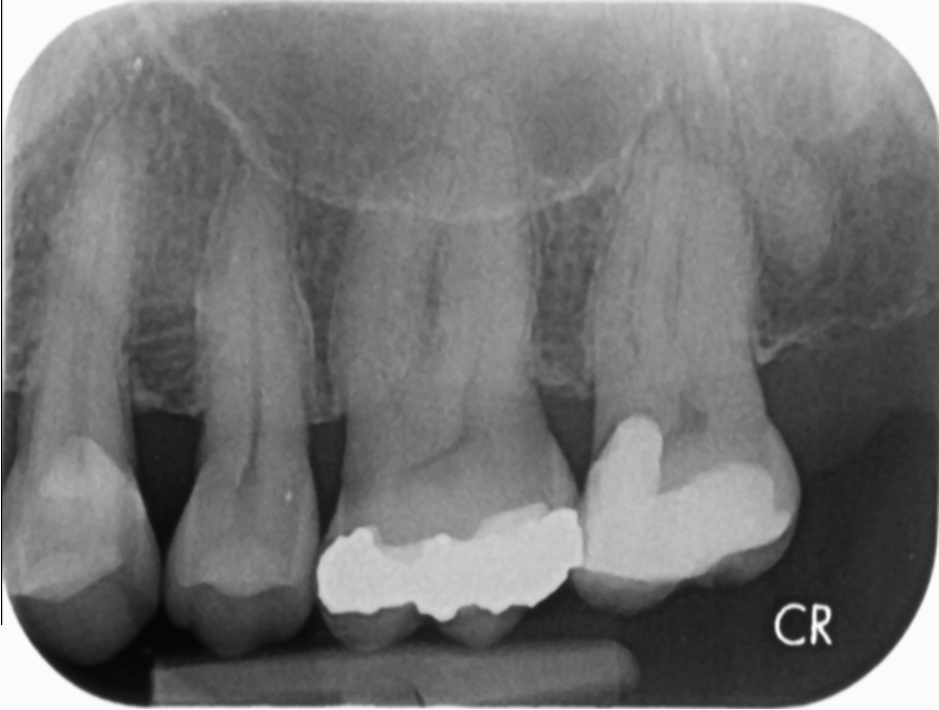

In [28]:
from IPython.display import Image 
pil_img = Image(filename=os.path.join(data_dict['train'], 'train1.jpg'))
display(pil_img)

In [50]:
targets

tensor([[0.00000, 1.00000, 0.88198, 0.25097, 0.23605, 0.34157],
        [0.00000, 1.00000, 0.06314, 0.96187, 0.11768, 0.07625],
        [0.00000, 1.00000, 0.88198, 0.95567, 0.23605, 0.08866],
        [1.00000, 1.00000, 0.70382, 0.22487, 0.10148, 0.13008],
        [1.00000, 1.00000, 0.65358, 0.52574, 0.09849, 0.12214],
        [1.00000, 0.00000, 0.20689, 0.50936, 0.12237, 0.11121],
        [1.00000, 1.00000, 0.70382, 0.92988, 0.10148, 0.13008]])

In [52]:
z = targets[:,2:]
# z[:, :2] = z[:, :2] - z[:, 2:]/2
# z[:, 2:] = z[:, :2] + z[:, 2:]
z*x_size

tensor([[564.46423, 160.62018, 151.06955, 218.60394],
        [ 40.40642, 615.59875,  75.31757,  48.80060],
        [564.46423, 611.62891, 151.06955,  56.74023],
        [450.44315, 143.91904,  64.94440,  83.25050],
        [418.28931, 336.47552,  63.03418,  78.16653],
        [132.40686, 325.98975,  78.31525,  71.17599],
        [450.44315, 595.12402,  64.94440,  83.25049]])

In [34]:
n_images, _, x_size, y_size = imgs.shape

In [73]:
batch_qtargets.shape, batch_qtargets

((2, 25200, 2),
 array([[[     0.2206,      0.7794],
         [    0.94505,    0.054949],
         [    0.75053,     0.24947],
         ...,
         [     0.3145,      0.6855],
         [    0.70746,     0.29254],
         [      0.436,       0.564]],
 
        [[    0.81003,     0.18997],
         [    0.29311,     0.70689],
         [    0.29124,     0.70876],
         ...,
         [    0.52489,     0.47511],
         [    0.96028,    0.039722],
         [    0.53114,     0.46886]]]))

In [71]:
for i in range(2):
    y = dataset.labels[i]
pil_img.data

b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x01\x01\x01\x01\x02\x01\x01\x01\x02\x02\x02\x02\x02\x04\x03\x02\x02\x02\x02\x05\x04\x04\x03\x04\x06\x05\x06\x06\x06\x05\x06\x06\x06\x07\t\x08\x06\x07\t\x07\x06\x06\x08\x0b\x08\t\n\n\n\n\n\x06\x08\x0b\x0c\x0b\n\x0c\t\n\n\n\xff\xdb\x00C\x01\x02\x02\x02\x02\x02\x02\x05\x03\x03\x05\n\x07\x06\x07\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\xff\xc0\x00\x11\x08\x02\xc6\x03\xab\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x94\x95\x96\x97\

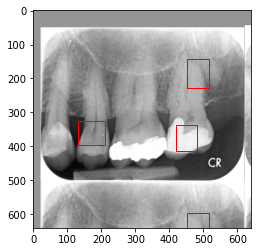

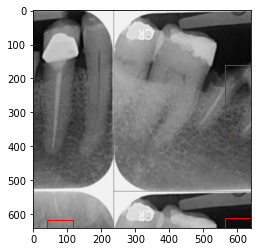

In [61]:
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib.patches as patches

fig, ax = plt.subplots()
imgplot = plt.imshow(np.transpose(imgs[1], (1, 2, 0)), cmap='gray')

for i in range(3, z.shape[0]):
    x, y, w, h = z[i]*x_size
    rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

fig, ax = plt.subplots()
imgplot = plt.imshow(np.transpose(imgs[0], (1, 2, 0)), cmap='gray')

for i in range(3):
    x, y, w, h = z[i]*x_size
    rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

In [ ]:
q_t, pcm_var, lb = VBi_yolo(cstargets_bcc, pred_bcc.cpu().detach().numpy(), pcm['variational'], pcm['prior'])

In [ ]:
lb

In [ ]:
z[:,...,5:]

In [ ]:
Counter(cstargets_bcc[1][:, 4])

In [ ]:
pred_bcc.shape

In [ ]:
pred_bcc = convert_yolo2bcc(pred_yolo.cpu().detach().numpy(), n_anchor_choices, nc, grid_ratios, intermediate_yolo_mode = True)
pred_bcc.shape, pred_bcc

In [ ]:
pred_yolo.shape, pred_bcc.shape

In [ ]:
from collections import Counter
Counter(pred_yolo[...,0].cpu().detach().numpy()[1]), Counter(pred_bcc[1])

In [ ]:
Counter(pred_yolo[0][:, 0].cpu().detach().numpy()), Counter(pred_bcc[0])

In [ ]:
pred_yolo[0, :4, :]

In [ ]:
y = pred_yolo.cpu().detach().numpy()
y.shape, y

In [ ]:
y.shape

In [ ]:
i = 0
effective_id = 0
points = {}
for g, gr in enumerate(grid_ratios):
    points[g] = {}
    cells_per_side = np.ceil(1/gr).astype(int)
    for a in range(3):
        points[g][a] = []
        for gc in range(cells_per_side**2):
            points[g][a].append(y[i, effective_id, [1,2]])
            effective_id += 1
        points[g][a] = np.array(points[g][a])
        print(f'(G{g}, A{a}): {points[g][a].shape[0]} points')

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline
a = 0
for g in range(3):
    r = grid_ratios[g]
    # x1,  = grid_ratios[0], 0
    fig, ax = plt.subplots(figsize=(20, 20))

    ax.set_xticks(np.arange(0, 1+r, r))
    ax.set_yticks(np.arange(0, 1+r, r))
    # ax.set_xticklabels([0, 1])
    ax.set_yticklabels([round(1-j, 2) for j in ax.get_yticks()])
    ax.set_xlim([-3*r, 1+3*r])
    ax.set_ylim([-3*r, 1+3*r])
    # ax.set_xlim([-3*r, 0.1])
    # ax.set_ylim([1-(-3*r), 1-0.1])
    plt.plot(points[g][a][:,0], 1-points[g][a][:,1], linestyle=' ', marker="x", markersize=5)
    plt.grid(True)
    plt.show()
    fig.autofmt_xdate()